This project was done on pc running Ubuntu 20.04 with Tensorflow 2.7, Cuda 11.2 and cuDNN 8.1 on an RTX3080 GPU with 10Gb of memory

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.7.0


Initialize random number generators. In this way we get same results on different runs of the notebook.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

#### EfficientNetB0

I chose the EfficientNetB0, as suggested by the lecturer. Link to [API](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0)

In [4]:
# Create the base model from the pre-trained model EfficientNet B0
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, # Exclude the decision part of the pretrained model, we will build our own
    weights='imagenet', # pretrained weights on the imagenet dataset
    input_shape=(224,224,3), # input shape to the model (shape of preprocessed malaria images)
    pooling="avg",  # add an average pooling layer on top
)
base_model.trainable = False # freeze the model

# Preprocessing and input pipelines.

Next I will implement some sort of input pipeline. It will consist of resizing the datasets. The data will also be augmented with random flips and rotations. Note! Rescaling layer is included in the pretrained net.


I chose the malaria dataset, as that only has two classes. That makes the training (hopefully) somewhat faster. <br>
Link to [dataset](https://www.tensorflow.org/datasets/catalog/malaria) <br>
From the docs: The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.

In [5]:
(train_ds, val_ds, test_ds), metadata = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True, with_info=True)

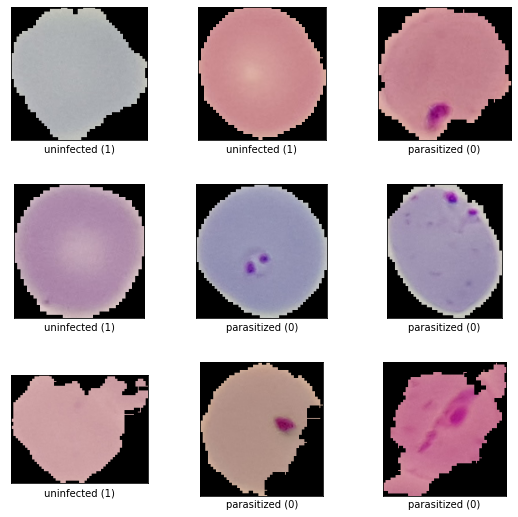

In [6]:
fig = tfds.show_examples(train_ds, metadata)

In [7]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


In [8]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

In [9]:
# add some padding to the images
padded_train_ds = (
    train_ds
    .map(pad)
) 

padded_val_ds = (
    val_ds
    .map(pad)
) 

padded_test_ds = (
     test_ds
    .map(pad)
) 

[Prefetching](https://www.tensorflow.org/guide/data_performance) <br>
Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

Note that the prefetch transformation provides benefits any time there is an opportunity to overlap the work of a "producer" with the work of a "consumer."

In [10]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

#augment the images with random flips and rotations

# Random flip: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
# Flips training images randomly either horizontally or vertically

# Random rotation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
# Flip images randomly during training, according to fractions of 2Pi. In this case the rotations are up to pi/4
# fill mode: The input is extended by filling all values beyond the edge with the same constant value k = 0.

# This data augmentation method should be classification invariant, i.e., the labels are not effected by transformations.

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.25, fill_mode="constant"),
])

IMG_SIZE = 224

# resize to input shape preferred by efficientnetB0
# this is 224x224 accoring to https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# API link: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing
# crop to aspect ratio should be the default, we have square images so it doesn't matter
resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE, crop_to_aspect_ratio=True),
  Rescaling(255)
])

batch_size = 32
#AUTOTUNE should automatically optimize performance
AUTOTUNE = tf.data.AUTOTUNE

#Function that implements data augmentation
def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets. 
  # Lambda function takes dataset as argument, resizes and rescales images, doesn't modify labels
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  # Lambda function takes dataset as argument, augments images, doesn't modify labels
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

# Show some cool examples of cells and illustration of data augmentation

In [11]:
get_label_name = metadata.features['label'].int2str

image_iterable = iter(padded_train_ds)

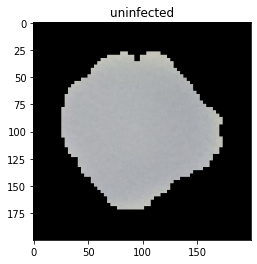

In [12]:
# rerun this cell to get other images

image, label = next(image_iterable)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

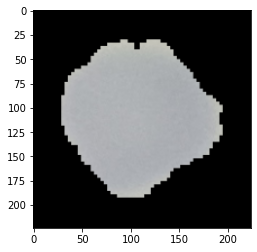

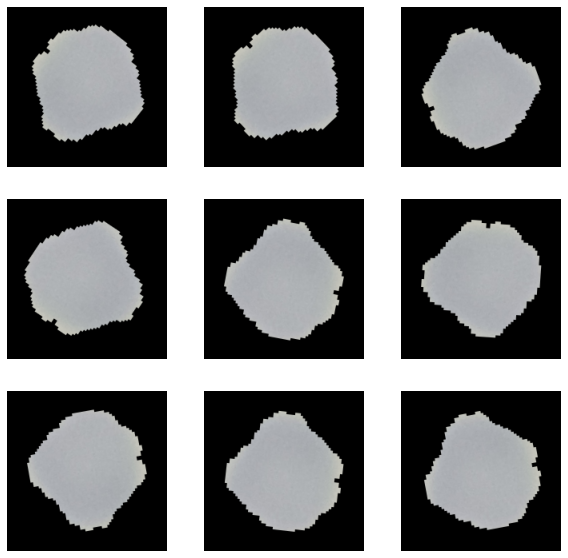

In [13]:
result = resize_and_rescale(image)
_ = plt.imshow(result/255)
# Add the image to a batch.
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [14]:
train_ds = prepare(padded_train_ds, shuffle=True, augment=True).repeat(2) # repeat 5 made training time very long. I'll run this with repeat 2-3 if I have time.
val_ds = prepare(padded_val_ds)
test_ds = prepare(padded_test_ds)

# It's time to build the model

In [15]:
# create new model on top
def create_model():
  input = Input(shape=(224, 224, 3))
  x = base_model(input, training=False)
  x = Dense(256, activation='relu')(x) # decision layer sizes according to Timo's suggestion
  x = Dense(64, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)
  return Model(inputs=input, outputs=predictions)

# create the model

model = create_model()

# freeze the base model layers
base_model.trainable = False

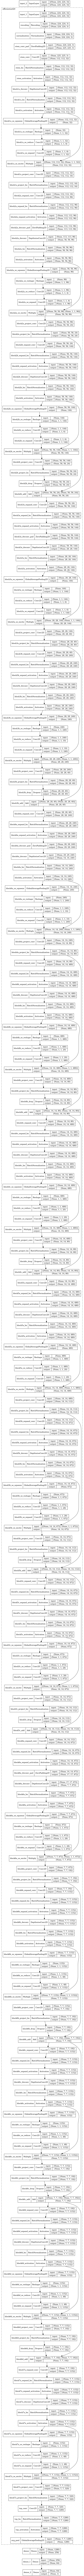

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,394,020
Trainable params: 344,449
Non-trainable params: 4,049,571
_________________________________________________________________


# Let's define checkpoint and early stopping callbacks

In [19]:
checkpoint_path = "models/transfer-net.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# to clarify this keeps one checkpoint saved, I think this is sufficient.
# in case something goes wrong you can always retrain the model.
# This serves as a starting point for fine-tuning.
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

# Now it's time to establish a baseline for performance

In [20]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20, # early stopping probably stops this before epoch 20
          verbose='auto',
          callbacks=callbacks)

Epoch 1/20
1206/1206 [==============================] - ETA: 0s - loss: 0.1631 - binary_accuracy: 0.9379
Epoch 00001: saving model to models/transfer-net.ckpt
1206/1206 [==============================] - 47s 35ms/step - loss: 0.1631 - binary_accuracy: 0.9379 - val_loss: 0.1373 - val_binary_accuracy: 0.9453
Epoch 2/20
1205/1206 [============================>.] - ETA: 0s - loss: 0.1325 - binary_accuracy: 0.9504
Epoch 00002: saving model to models/transfer-net.ckpt
1206/1206 [==============================] - 39s 32ms/step - loss: 0.1326 - binary_accuracy: 0.9503 - val_loss: 0.1390 - val_binary_accuracy: 0.9441
Epoch 3/20
1206/1206 [==============================] - ETA: 0s - loss: 0.1250 - binary_accuracy: 0.9536
Epoch 00003: saving model to models/transfer-net.ckpt
1206/1206 [==============================] - 39s 32ms/step - loss: 0.1250 - binary_accuracy: 0.9536 - val_loss: 0.1170 - val_binary_accuracy: 0.9550
Epoch 4/20
1204/1206 [============================>.] - ETA: 0s - loss: 0.11

In [21]:
model.evaluate(test_ds)

130/130 [==============================] - 4s 27ms/step - loss: 0.1319 - binary_accuracy: 0.9555


[0.13191989064216614, 0.9554910659790039]

# Plot history

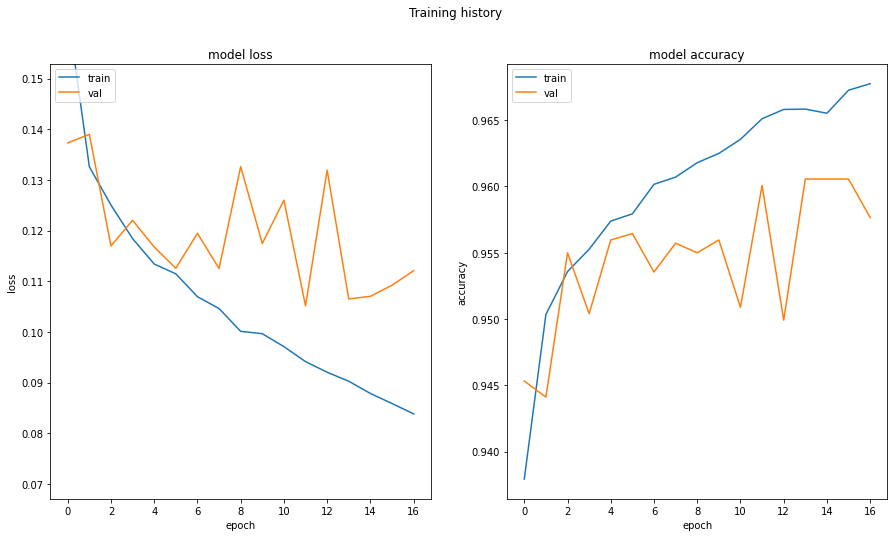

In [22]:
def plot_training_metrics(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
  fig.suptitle('Training history')

  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('model loss')
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'val'], loc='upper left')
  ax1.set_ylim(min(history.history['loss'])*0.8, max(history.history['val_loss'])*1.1)

  ax2.plot(history.history['binary_accuracy'])
  ax2.plot(history.history['val_binary_accuracy'])
  ax2.set_title('model accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'val'], loc='upper left')

  plt.show()

plot_training_metrics(history)

We can see from the plot that training loss and accuracy were steadily improving. However, validation loss and accuracy was already fluctuating after about epoch 3. <br>
Further training would increase risk of overfitting, as our training data was pretty compact. It's time to try fine-tuning the model.

# Fine-tuning the model

Let's try to fine-tune the model by opening up a few layers. First we will open up first layer block, and then in the second iteration the second layer block.

In [23]:
print(model.summary())
trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_params)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,394,020
Trainable params: 344,449
Non-trainable params: 4,049,571
_________________________________________________________________
None
344449


In [24]:
# Loads the weights
model.load_weights(checkpoint_path).expect_partial()

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - 1)

# Unfreeze block 1
base_model.trainable = True

for layer in base_model.layers:
    if "block1" not in layer.name:
        layer.trainable = False
# This opened up  1448 parameters for training.


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# default learning rate in Adam is  0.001. 1e-6 is much smaller
adam = tf.keras.optimizers.Adam(
    learning_rate=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())
trainable_params_2 = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_params_2 - trainable_params)
print(model.summary())

130/130 - 3s - loss: 0.1319 - binary_accuracy: 0.9555 - 3s/epoch - 26ms/step
Restored model, validation accuracy: 95.55%
Number of layers in the base model:  238
Number of layers in the decision model:  4
1448
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                 

Epoch 17/46
1206/1206 [==============================] - ETA: 0s - loss: 0.0898 - binary_accuracy: 0.9677
Epoch 00017: saving model to models/transfer-net-finetuned.ckpt
1206/1206 [==============================] - 158s 128ms/step - loss: 0.0898 - binary_accuracy: 0.9677 - val_loss: 0.1188 - val_binary_accuracy: 0.9574
Epoch 18/46
1206/1206 [==============================] - ETA: 0s - loss: 0.0862 - binary_accuracy: 0.9680
Epoch 00018: saving model to models/transfer-net-finetuned.ckpt
1206/1206 [==============================] - 154s 127ms/step - loss: 0.0862 - binary_accuracy: 0.9680 - val_loss: 0.1081 - val_binary_accuracy: 0.9620
Epoch 19/46
1206/1206 [==============================] - ETA: 0s - loss: 0.0824 - binary_accuracy: 0.9701
Epoch 00019: saving model to models/transfer-net-finetuned.ckpt
1206/1206 [==============================] - 156s 129ms/step - loss: 0.0824 - binary_accuracy: 0.9701 - val_loss: 0.1018 - val_binary_accuracy: 0.9630
Epoch 20/46
1206/1206 [==============

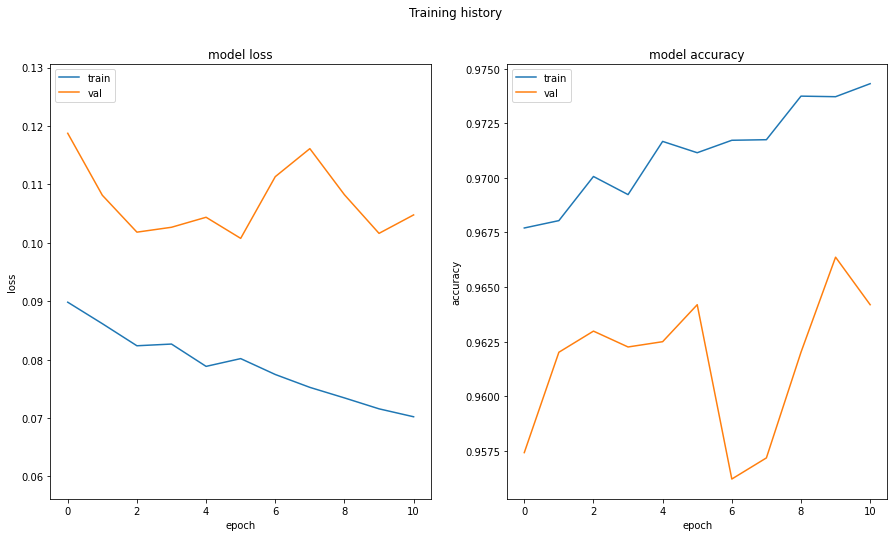

130/130 - 3s - loss: 0.1269 - binary_accuracy: 0.9591 - 3s/epoch - 25ms/step
Fine-tuned model, validation accuracy: 95.91%


In [25]:
ft_checkpoint_path = "models/transfer-net-finetuned.ckpt"
ft_checkpoint_dir = os.path.dirname(ft_checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

fine_tune_epochs = 30
total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Fine-tuned model, validation accuracy: {:5.2f}%".format(100 * acc))

We can see from the fine-tuning training epochs that training loss and training accuracy were improving steadily. However, it's unclear from the validation loss and accuracy if significant progress was actually made.

#### Fine-tuning, round 2
Let's now unfreeze the second layer block and repeat the training otherwise in an identical manner.

In [26]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,394,020
Trainable params: 345,897
Non-trainable params: 4,048,123
_________________________________________________________________
None


In [27]:
# Loads the weights
model.load_weights(ft_checkpoint_path).expect_partial()

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - 1)

# Unfreeze block 1
base_model.trainable = True

for layer in base_model.layers:
    if "block2" not in layer.name:
        layer.trainable = False
# This opened up about 15266 parameters for training.


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# default learning rate in Adam is  0.001. 1e-6 is much smaller
adam = tf.keras.optimizers.Adam(
    learning_rate=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())
trainable_params_3 = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_params_3 - trainable_params_2)
print(model.summary())

130/130 - 3s - loss: 0.1269 - binary_accuracy: 0.9591 - 3s/epoch - 25ms/step
Restored model, validation accuracy: 95.91%
Number of layers in the base model:  238
Number of layers in the decision model:  4
15266
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                

Epoch 27/56
1206/1206 [==============================] - ETA: 0s - loss: 0.0879 - binary_accuracy: 0.9685
Epoch 00027: saving model to models/transfer-net-finetuned-2.ckpt
1206/1206 [==============================] - 116s 94ms/step - loss: 0.0879 - binary_accuracy: 0.9685 - val_loss: 0.0869 - val_binary_accuracy: 0.9652
Epoch 28/56
1206/1206 [==============================] - ETA: 0s - loss: 0.0779 - binary_accuracy: 0.9716
Epoch 00028: saving model to models/transfer-net-finetuned-2.ckpt
1206/1206 [==============================] - 113s 94ms/step - loss: 0.0779 - binary_accuracy: 0.9716 - val_loss: 0.0839 - val_binary_accuracy: 0.9678
Epoch 29/56
1206/1206 [==============================] - ETA: 0s - loss: 0.0717 - binary_accuracy: 0.9741
Epoch 00029: saving model to models/transfer-net-finetuned-2.ckpt
1206/1206 [==============================] - 113s 94ms/step - loss: 0.0717 - binary_accuracy: 0.9741 - val_loss: 0.0877 - val_binary_accuracy: 0.9681
Epoch 30/56
1206/1206 [===========

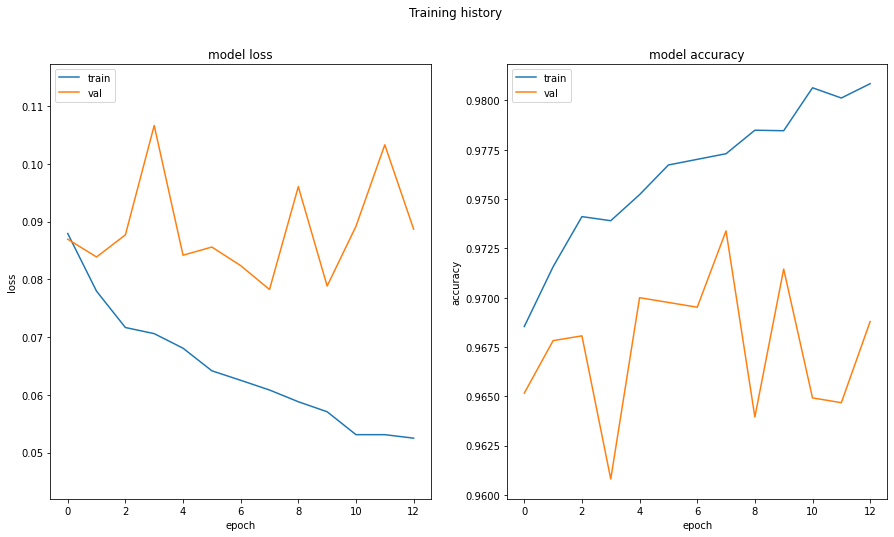

130/130 - 3s - loss: 0.1007 - binary_accuracy: 0.9678 - 3s/epoch - 22ms/step
Fine-tuned model, test accuracy: 96.78%


In [28]:
ft_checkpoint_path_2 = "models/transfer-net-finetuned-2.ckpt"
ft_checkpoint_dir_2 = os.path.dirname(ft_checkpoint_path_2)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_2,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

fine_tune_epochs = 30
total_epochs =  history_fine.epoch[-1] + fine_tune_epochs

history_fine_2 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine_2)
# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Fine-tuned model, test accuracy: {:5.2f}%".format(100 * acc))

With the second round of fine-tuning the training loss and accuracy were once again improving. However, the validation loss and accuracy seem to be fluctuating around randomly.

In [29]:
# Loads the weights from previous checkpoint
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored baseline model, accuracy: {:5.2f}%".format(100 * acc))

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_2)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

130/130 - 3s - loss: 0.1319 - binary_accuracy: 0.9555 - 3s/epoch - 26ms/step
Restored baseline model, accuracy: 95.55%
130/130 - 3s - loss: 0.1007 - binary_accuracy: 0.9678 - 3s/epoch - 27ms/step
Restored fine-tuned model, accuracy: 96.78%


## Train the model again with L2 regularization, batch normalization, dropout layer and learning rate scheduler

Let's implement the above changes to the model and compare the result to the model trained with Adam.

In [30]:
# create new model on top
def create_model():
  input = Input(shape=(224, 224, 3))
  x = base_model(input, training=False)
  x = BatchNormalization()(x)
  x = Dense(256, activation='relu', kernel_regularizer='l2')(x) # decision layer sizes according to Timo's suggestion
  x = Dense(64, activation='relu', kernel_regularizer='l2')(x)
  x = Dropout(0.1)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  return Model(inputs=input, outputs=predictions)

# create the model

model = create_model()

# freeze the base model layers
base_model.trainable = False

In [31]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=500,
    decay_rate=0.9)

SGD = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.8, nesterov=False,
)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_metric = get_lr_metric(SGD)

model.compile(optimizer=SGD, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), lr_metric])
trainable_lr_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_lr_params)

347009


In [32]:
checkpoint_path_lr = "models/transfer-net-lr.ckpt"
checkpoint_dir_lr = os.path.dirname(checkpoint_path_lr)

# Create a callback that saves the model's weights
# to clarify this keeps one checkpoint saved, I think this is sufficient.
# in case something goes wrong you can always retrain the model.
# This serves as a starting point for fine-tuning.
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_lr,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

history_lr = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20, # early stopping probably stops this before epoch 20
          verbose='auto',
          callbacks=callbacks)

Epoch 1/20
1206/1206 [==============================] - ETA: 0s - loss: 2.2254 - binary_accuracy: 0.9632 - lr: 0.0088
Epoch 00001: saving model to models/transfer-net-lr.ckpt
1206/1206 [==============================] - 42s 33ms/step - loss: 2.2254 - binary_accuracy: 0.9632 - lr: 0.0088 - val_loss: 0.7305 - val_binary_accuracy: 0.9685 - val_lr: 0.0078
Epoch 2/20
1206/1206 [==============================] - ETA: 0s - loss: 0.4114 - binary_accuracy: 0.9686 - lr: 0.0068
Epoch 00002: saving model to models/transfer-net-lr.ckpt
1206/1206 [==============================] - 39s 32ms/step - loss: 0.4114 - binary_accuracy: 0.9686 - lr: 0.0068 - val_loss: 0.2228 - val_binary_accuracy: 0.9702 - val_lr: 0.0060
Epoch 3/20
1205/1206 [============================>.] - ETA: 0s - loss: 0.1794 - binary_accuracy: 0.9691 - lr: 0.0053
Epoch 00003: saving model to models/transfer-net-lr.ckpt
1206/1206 [==============================] - 39s 32ms/step - loss: 0.1794 - binary_accuracy: 0.9691 - lr: 0.0053 - va

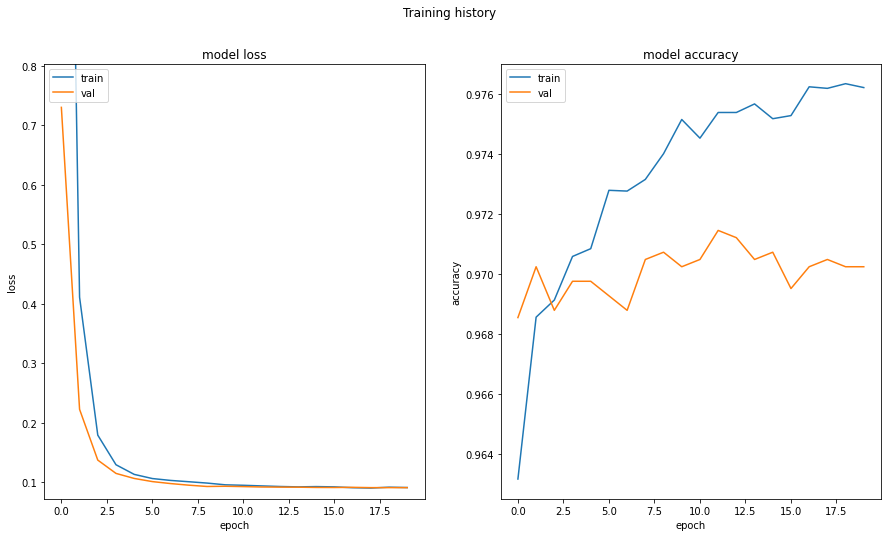

130/130 - 3s - loss: 0.1020 - binary_accuracy: 0.9719 - lr: 6.2038e-05 - 3s/epoch - 25ms/step
Model, test accuracy: 97.19%


In [33]:
plot_training_metrics(history_lr)
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Model, test accuracy: {:5.2f}%".format(100 * acc))

With SGD the training and validation loss seem to be steadily improving. The early stopping callback didn't stop training. Training accuracy was steadily improving, and even validation accuracy seemed to be making slow progress. The model seems to reach a very good accuracy already after the first round of training, beating the model trained with Adam.

### Fine-tune the model by unfreezing the first layer block

130/130 - 3s - loss: 0.1020 - binary_accuracy: 0.9719 - lr: 6.2038e-05 - 3s/epoch - 25ms/step
Restored model, test accuracy: 97.19%
Number of layers in the base model:  238
Number of layers in the decision model:  6
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dense_4 (Dense)             (None, 64)  

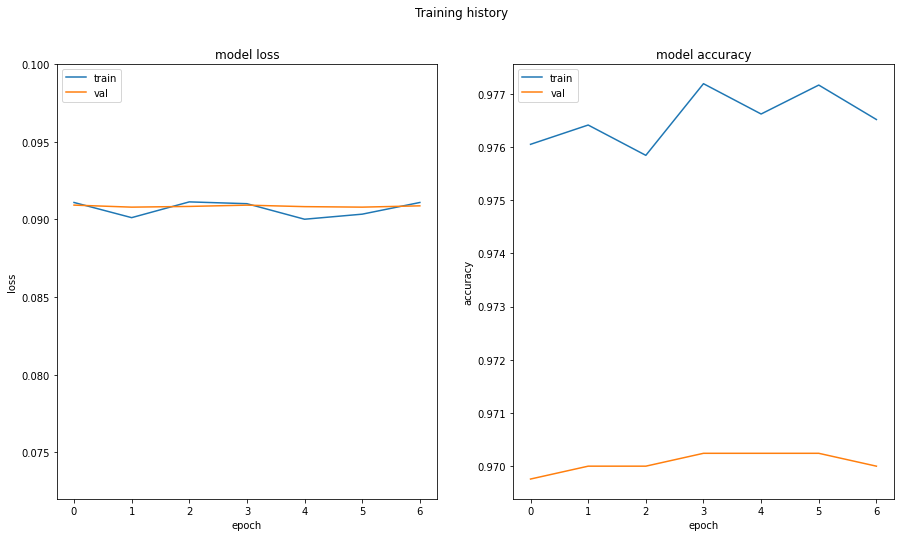

130/130 - 3s - loss: 0.1019 - binary_accuracy: 0.9722 - lr: 1.6882e-06 - 3s/epoch - 23ms/step
Fine-tuned model, validation accuracy: 97.22%


In [34]:
# Loads the weights
model.load_weights(checkpoint_path_lr).expect_partial()

# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - 1)

# Unfreeze block 1
base_model.trainable = True

for layer in base_model.layers:
    if "block1" not in layer.name:
        layer.trainable = False
# This opened up 1448 parameters for training.


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
# default learning rate in SGD is  0.01. 1e-5 is much smaller

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=500,
    decay_rate=0.9)

SGD = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.8, nesterov=False,
)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_metric = get_lr_metric(SGD)

model.compile(optimizer=SGD, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), lr_metric])
print(model.summary())
trainable_lr_params_2 = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_lr_params_2 - trainable_lr_params)

ft_checkpoint_path_lr_ft = "models/transfer-net-finetuned-lr-ft.ckpt"
ft_checkpoint_dir_lr_ft = os.path.dirname(ft_checkpoint_path_lr_ft)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_lr_ft,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

fine_tune_epochs = 30
total_epochs =  history_lr.epoch[-1] + fine_tune_epochs

history_lr_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_lr_fine)
# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Fine-tuned model, validation accuracy: {:5.2f}%".format(100 * acc))

Here the curves are pretty flat. Perhaps the learning rate was too small?

### Fine-tune the model by unfreezing the second layer block

130/130 - 3s - loss: 0.1019 - binary_accuracy: 0.9722 - lr: 1.0000e-05 - 3s/epoch - 25ms/step
Restored model, test accuracy: 97.22%
Number of layers in the base model:  238
Number of layers in the decision model:  6
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dense_4 (Dense)             (None, 64)  

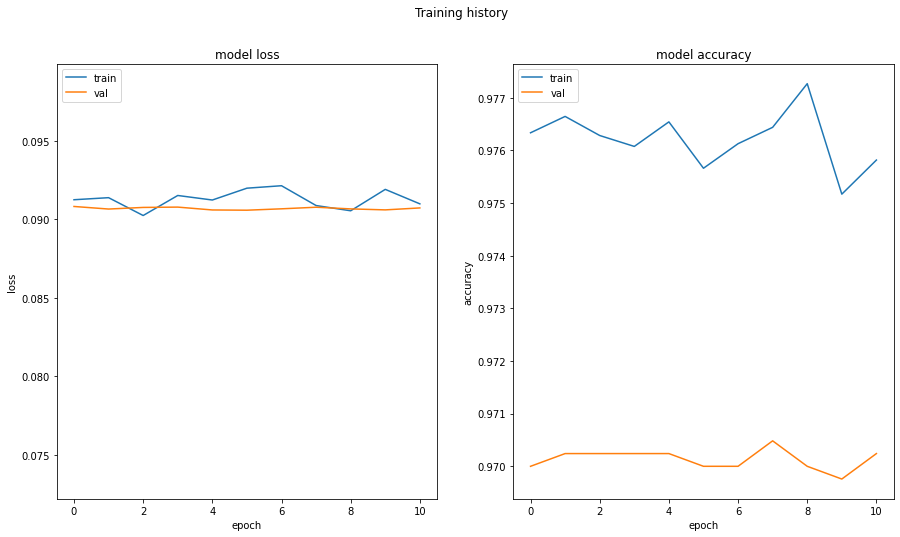

130/130 - 3s - loss: 0.1019 - binary_accuracy: 0.9727 - lr: 6.1089e-07 - 3s/epoch - 26ms/step
Fine-tuned model, test accuracy: 97.27%


In [36]:
# Loads the weights
model.load_weights(ft_checkpoint_path_lr_ft).expect_partial()

# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - 1)

# Unfreeze block 1
base_model.trainable = True

for layer in base_model.layers:
    if "block2" not in layer.name:
        layer.trainable = False
# This opened up 15266 parameters for training.


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
# default learning rate in SGD is  0.01. 1e-5 is much smaller

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=500,
    decay_rate=0.9)

SGD = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.8, nesterov=False,
)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_metric = get_lr_metric(SGD)

model.compile(optimizer=SGD, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), lr_metric])
print(model.summary())
trainable_lr_params_3 = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(trainable_lr_params_3 - trainable_lr_params_2)

ft_checkpoint_path_lr_ft_2 = "models/transfer-net-finetuned-lr-2.ckpt"
ft_checkpoint_dir_lr_ft_2 = os.path.dirname(ft_checkpoint_path_lr_ft_2)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_lr_ft_2,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False), cp_callback]

fine_tune_epochs = 30
total_epochs =  history_lr_fine.epoch[-1] + fine_tune_epochs

history_lr_fine_2 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_lr_fine_2)
# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Fine-tuned model, test accuracy: {:5.2f}%".format(100 * acc))

After the second round of fine-tuning it is not clear if further progress has been made. Parhaps the learning rate was too small or the model had already converged? The SGD model did beat the Adam model by a relatively large margin.

## Compare the two methods of training the model.

We first trained the model with optimizer Adam and no L2 regularization, learning rate scheduling, batch normalization or dropout. <br>
On  the second run we added the above methods, but trained the model otherwise in an identical manner with SGD and learning rate scheduler.
Let's now compare the final models.

In [37]:
# Loads the weights from previous checkpoint
model.load_weights(checkpoint_path_lr)

# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Restored baseline model, accuracy: {:5.2f}%".format(100 * acc))

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_lr_ft_2)

# Re-evaluate the model
loss, acc, lr = model.evaluate(test_ds, verbose=2)
print("Restored fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

130/130 - 4s - loss: 0.1020 - binary_accuracy: 0.9719 - lr: 6.2038e-08 - 4s/epoch - 28ms/step
Restored baseline model, accuracy: 97.19%
130/130 - 4s - loss: 0.1019 - binary_accuracy: 0.9727 - lr: 6.1089e-07 - 4s/epoch - 27ms/step
Restored fine-tuned model, accuracy: 97.27%


# Results

Model trained with Adam reached a baseline accuracy of 95.55%. With fine-tuning the model accracy improved to 96.78%. <br>
The model trained with SGD with momentum and learning rate scheduler reached a baseline accuracy of 97.19%. The SGD model accuracy didn't improve significantly with fine-tuning. The final accuracy was 97.27%

## Examples of erroneous predictions

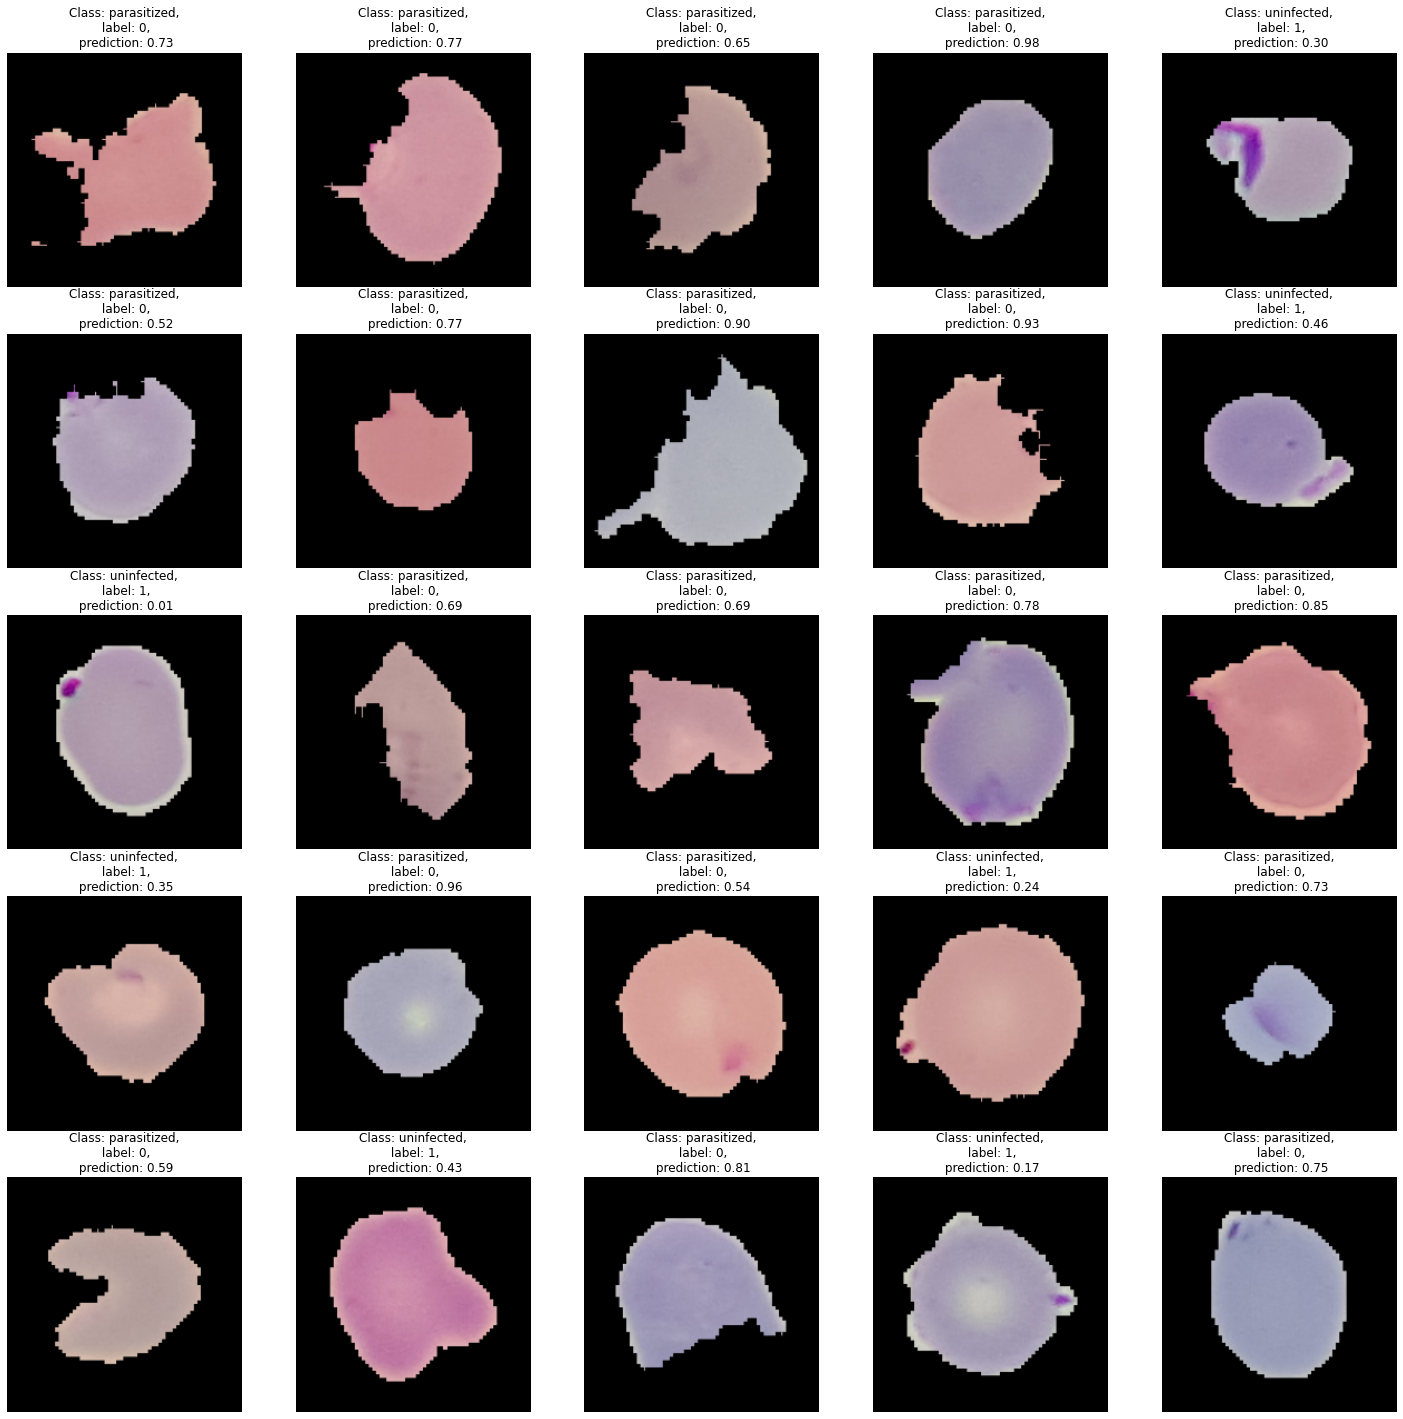

In [38]:
plt.figure(figsize=(25, 25))

false_predictions = 0

for set in test_ds:

    if false_predictions == 25:
      break

    predictions = model.predict(set[0])
    for i in range(len(predictions)):

        label = int(set[1][i])

        if label != round(predictions[i][0]):
          false_predictions += 1
          label_name = get_label_name(label)
          prediction = predictions[i]
          ax = plt.subplot(5, 5, false_predictions)
          plt.imshow(set[0][i]/255)
          plt.axis("off")
          ax.set_title(f'Class: {label_name},\n label: {label},\n prediction: {"%.2f" % prediction[0]}')
          if false_predictions == 25:
            break
plt.show()

### Some thought on the erroneous predictions

It seems that the erroneous examples mostly consist of samples that seem to have a different label that one would expect from the other samples.
That is, the erroneously classified samples are either uninfected looking cells that are actually infected or vice versa. Could these samples be artificially increased in the training data set? Well, maybe.

You could go through the data set and label the samples by hand as hard to identify or easy to identify. You could then duplicate (with augmentation) the hard to identify ones a few times in the data set. This, however, seems like a lot of work.

Another option would be to train a few "probe" models on small training sets and check out which data items are hard to classify for those probe models. You could identify some subset of the training data set that is hard to classify for the probe models and duplicate that subset with augmentation in the training data. Then you would train the actual model on the resulting data set.

This would be an interesting approach, but perhaps it's too much for the scope of this project.